In [1]:
import model
import utils
import jax.numpy as jnp
import jax
import einops
import optax
import numpy as np

import matplotlib.pyplot as plt
import ipdb
import tqdm.notebook as tqdm
import pprint

## Generate 3 Tasks


In [2]:
sampling_rate = 0.05
duration = 10
T = int(duration/sampling_rate)


SHOOTING_LAMBDAS = {
    'target': 1000,
    'transition': 1,
    'activation_energy': 1,
    'activation_positivity': 100,
    'readout_energy': 1,
    'transition_energy': 1
}


def generate_data(D, freqs, sampling_rate, duration, noise=False):
    time_bins = jnp.arange(0, duration, sampling_rate)
    omega_t = einops.rearrange(time_bins, 't->t ()') * freqs
    data = jnp.sin(omega_t)
    if noise:
        data += jax.random.normal(jax.random.PRNGKey(42), data.shape) * 0.02

    x_init = jax.random.uniform(jax.random.PRNGKey(42), (int(duration/sampling_rate),len(freqs),D),
                                        minval=0,
                                        maxval=1)
    return data, x_init

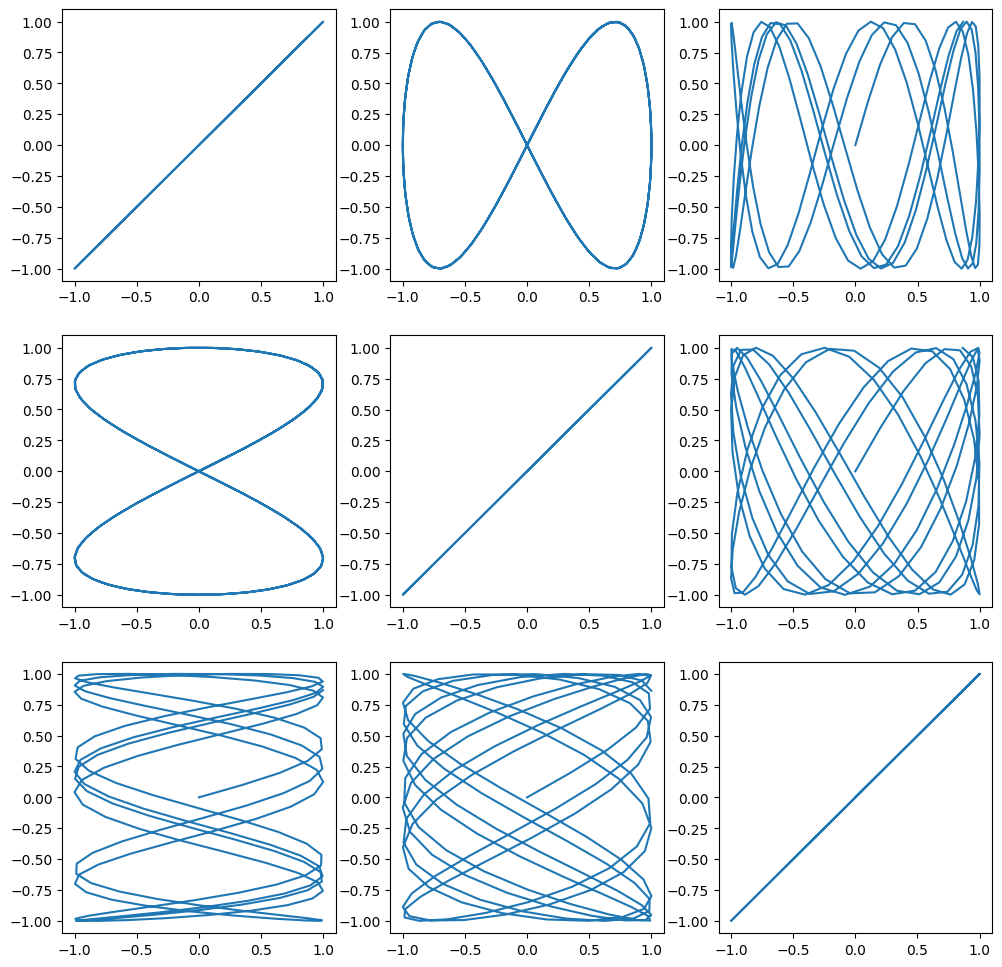

In [166]:
D = 6
##Modularising values: (3,7)
angular_freqs = jnp.array([2,4,7.1])
teacher_y, x_init =generate_data(D,angular_freqs, sampling_rate, duration)
d = teacher_y.shape[1]
fig, axes = plt.subplots(d, d, figsize=(12, 12))
for i in range(d):
    for j in range(d):
        ax = axes[i, j]
        ax.plot(teacher_y[:, i], teacher_y[:, j])
        #ax.plot(teacher_y[:, i] + teacher_y[:, j])

In [43]:
## Again, make it better with shooting 

SHOOTING_LAMBDAS = {
    'target': 1000,
    'transition': 1,
    'activation_energy': 1,
    'activation_positivity': 100,
    'readout_energy': 1,
    'transition_energy': 1
}
key = jax.random.PRNGKey(46)
K = len(angular_freqs)
shooting_student = model.ShootingModel(
    K=K,
    D=D,
    T=T,
    key=key,
    lambdas=SHOOTING_LAMBDAS,
    x0=None,
    W=None,
    R=None,
    bw=None,
    br=None,
    sigma = 1e-2)
optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(shooting_student)
for _ in tqdm.trange(int(5e5)):
    key, subkey = jax.random.split(key)
    shooting_student, optimizer_state, shooting_student_aux = model.train_step(shooting_student, optimizer_state, optimizer, teacher_y, key=subkey)
    if _ % 5e4 == 0:
        pprint.pprint(shooting_student_aux['losses'])

  0%|          | 0/500000 [00:00<?, ?it/s]

{'activation_energy': Array(0.00011535, dtype=float32),
 'activation_positivity': Array(3.6302252e-05, dtype=float32),
 'readout_energy': Array(8.720058e-05, dtype=float32),
 'target': Array(0.4989192, dtype=float32),
 'transition': Array(9.394479e-10, dtype=float32),
 'transition_energy': Array(8.783376e-05, dtype=float32)}
{'activation_energy': Array(0.03621456, dtype=float32),
 'activation_positivity': Array(0.00010365, dtype=float32),
 'readout_energy': Array(0.06743856, dtype=float32),
 'target': Array(0.32199544, dtype=float32),
 'transition': Array(0.00068692, dtype=float32),
 'transition_energy': Array(0.00711214, dtype=float32)}
{'activation_energy': Array(0.06759457, dtype=float32),
 'activation_positivity': Array(0.00031247, dtype=float32),
 'readout_energy': Array(0.14338341, dtype=float32),
 'target': Array(0.1639983, dtype=float32),
 'transition': Array(0.00119316, dtype=float32),
 'transition_energy': Array(0.01467249, dtype=float32)}
{'activation_energy': Array(0.086570

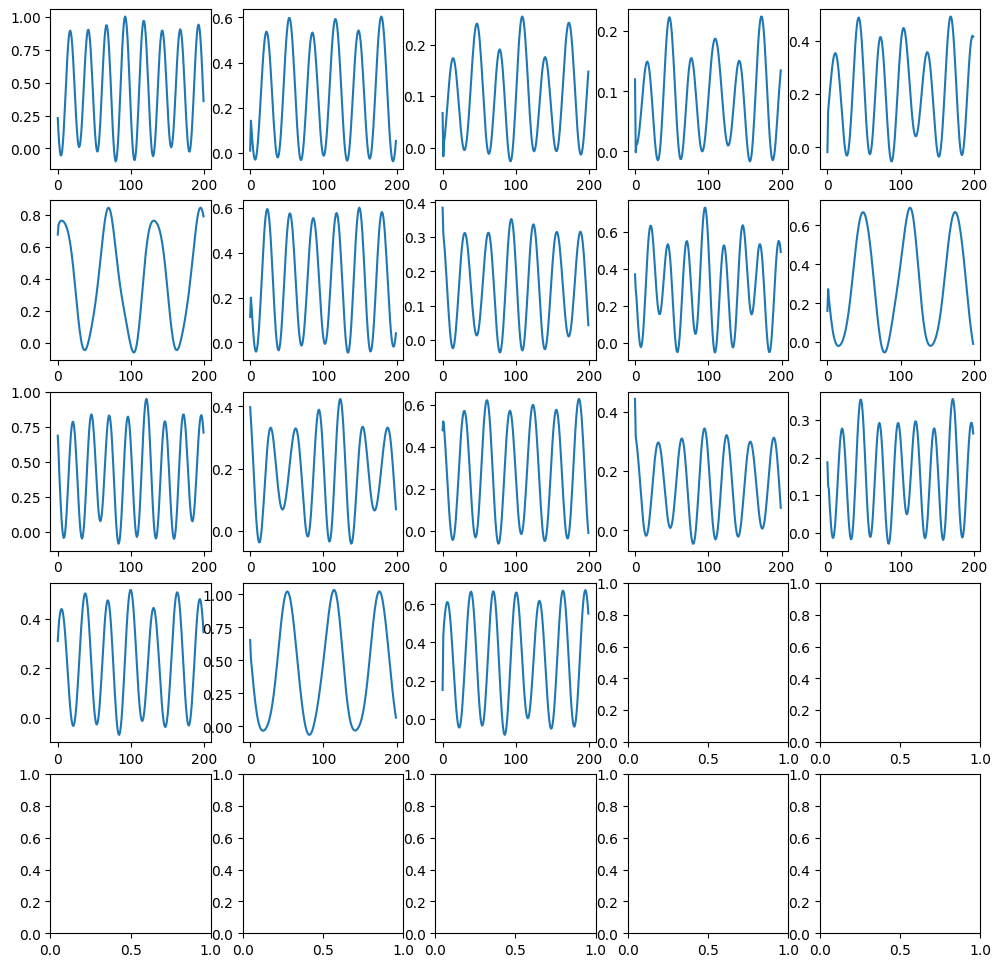

In [44]:
fig, axes = plt.subplots(int(jnp.ceil(jnp.sqrt(K*D))), int(jnp.ceil(jnp.sqrt(K*D))), figsize=(12, 12))
for i in range(K * D):
    ax = axes[i // int(jnp.ceil(jnp.sqrt(K * D))),
              i % int(jnp.ceil(jnp.sqrt(K * D)))]
    ax.plot(shooting_student_aux['x'][:, i])

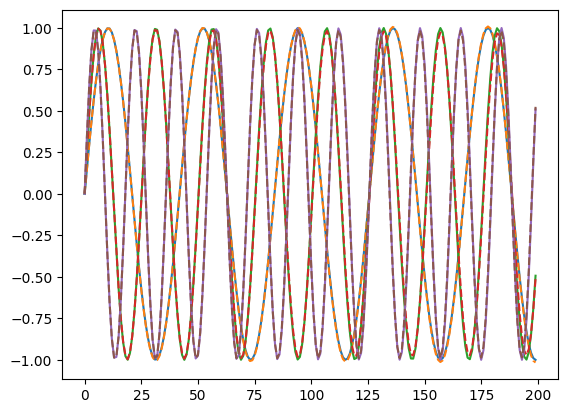

In [41]:
for i in range(K):
    plt.plot(teacher_y[:,i])
    plt.plot(shooting_student_aux['y_pred'][:,i], '--')

Now we want to feed the network with different input pairs and see how does it learn

In [3]:
import itertools 

sampling_rate = 0.05
duration = 10
T = int(duration/sampling_rate)

def generate_multitask_data(D, freqs, pair_size, sampling_rate, duration, noise=False):
    time_bins = jnp.arange(0, duration, sampling_rate)
    omega_t = einops.rearrange(time_bins, 't->t ()') * freqs
    data = jnp.sin(omega_t)
    if noise:
        data += jax.random.normal(jax.random.PRNGKey(42), data.shape) * 0.02

    x_init = jax.random.uniform(jax.random.PRNGKey(42), (int(duration/sampling_rate),len(freqs),D),
                                        minval=0,
                                        maxval=1)
    
    combi_tasks = list(itertools.combinations(np.arange(len(freqs)), pair_size))

    data_sets = dict()
    for combi in combi_tasks:
        combi_vect = np.zeros(len(freqs))
        combi_vect[list(combi)] = 1
        data_sets[tuple(combi_vect)] = data[:, combi]


    return data_sets

In [4]:
angular_freqs = jnp.array([2,4,7.1])
datasets = generate_multitask_data(4, angular_freqs, 2, sampling_rate, duration)

/Users/jin/anaconda3/envs/modular/lib/python3.12/site-packages/jax/_src/dtypes.py:653: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dt = np.result_type(x)


In [5]:
## Again, make it better with shooting
D= 6
key = jax.random.PRNGKey(46)
K = 2
SHOOTING_LAMBDAS = {
    'target': 1000,
    'transition': 1,
    'activation_energy': 100,
    'activation_positivity': 100,
    'readout_energy': 1,
    'transition_energy': 1
}
shooting_student = model.ShootingMultitaskModel(
    K=K,
    D=D,
    T=T,
    key=key,
    lambdas=SHOOTING_LAMBDAS,
    x0=None,
    W=None,
    R=None,
    bw=None,
    br=None,
    sigma = 1e-2)
optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(shooting_student)
for _ in tqdm.trange(int(1e6)):
    key, subkey = jax.random.split(key)
    shooting_student, optimizer_state, shooting_student_aux = model.train_step(shooting_student, optimizer_state, optimizer, y=datasets[(0,1,1)], key=subkey, T_pulse = 10, u_index = [0], )
    shooting_student, optimizer_state, shooting_student_aux = model.train_step(shooting_student, optimizer_state, optimizer, y=datasets[(1,0,1)], key=subkey, T_pulse = 10, u_index = [1], )
    #shooting_student, optimizer_state, shooting_student_aux = model.train_step(shooting_student, optimizer_state, optimizer, y=datasets[(1,1,0)], key=subkey, T_pulse = 10, u_index = [2], )
    
    if _ % 1e5 == 0:
        pprint.pprint(shooting_student_aux['losses'])

  0%|          | 0/1000000 [00:00<?, ?it/s]

{'activation_energy': Array(4.216981e-05, dtype=float32),
 'activation_positivity': Array(2.2748018e-05, dtype=float32),
 'readout_energy': Array(8.528952e-05, dtype=float32),
 'target': Array(0.49513182, dtype=float32),
 'transition': Array(4.204982e-08, dtype=float32),
 'transition_energy': Array(9.8556375e-05, dtype=float32)}
{'activation_energy': Array(0.00838002, dtype=float32),
 'activation_positivity': Array(0.00217912, dtype=float32),
 'readout_energy': Array(1.2291499, dtype=float32),
 'target': Array(0.00035412, dtype=float32),
 'transition': Array(0.00054757, dtype=float32),
 'transition_energy': Array(0.05829181, dtype=float32)}
{'activation_energy': Array(0.00844668, dtype=float32),
 'activation_positivity': Array(0.00219028, dtype=float32),
 'readout_energy': Array(1.1344354, dtype=float32),
 'target': Array(0.00020743, dtype=float32),
 'transition': Array(0.00053773, dtype=float32),
 'transition_energy': Array(0.05860984, dtype=float32)}
{'activation_energy': Array(0.008

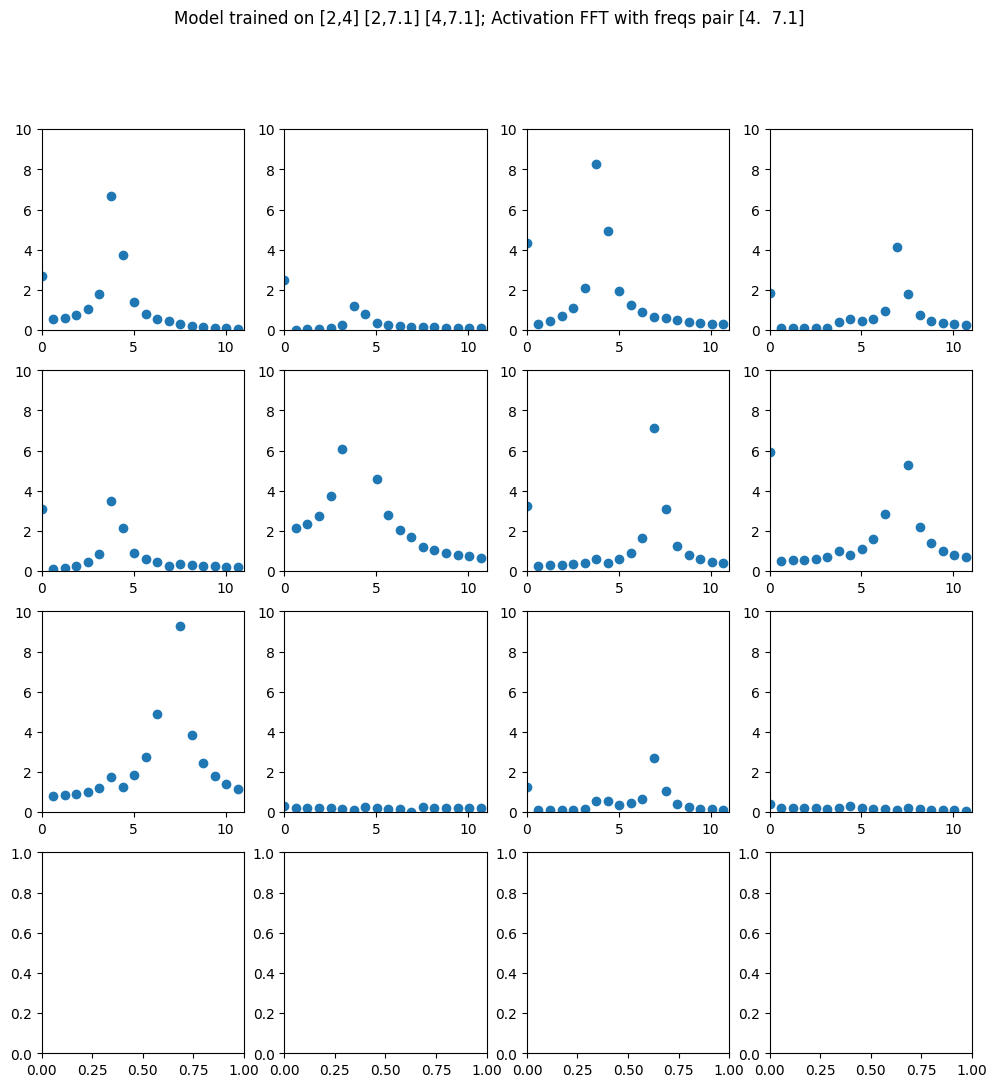

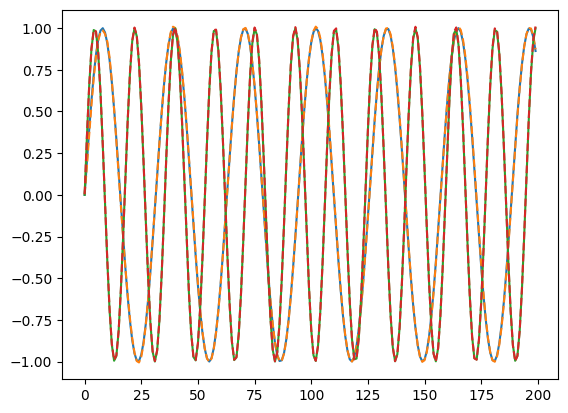

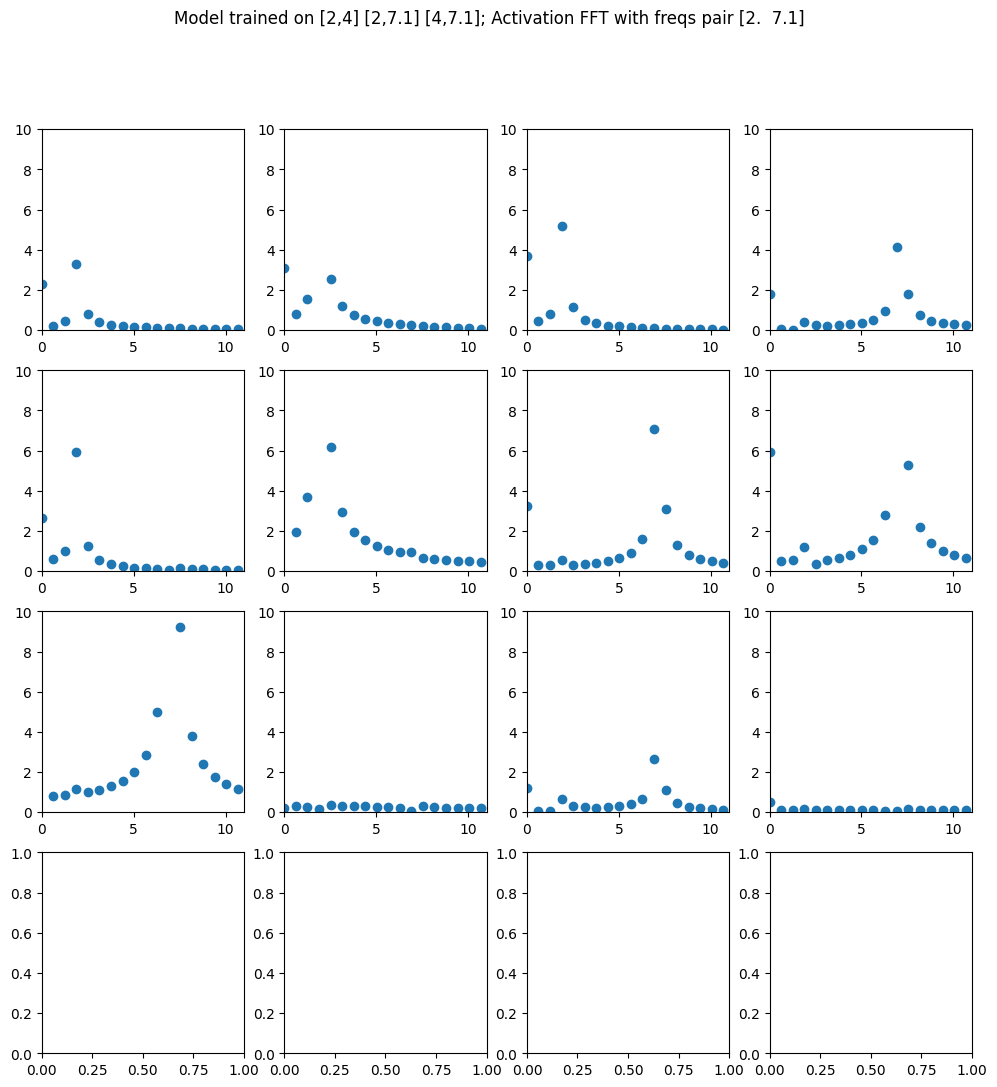

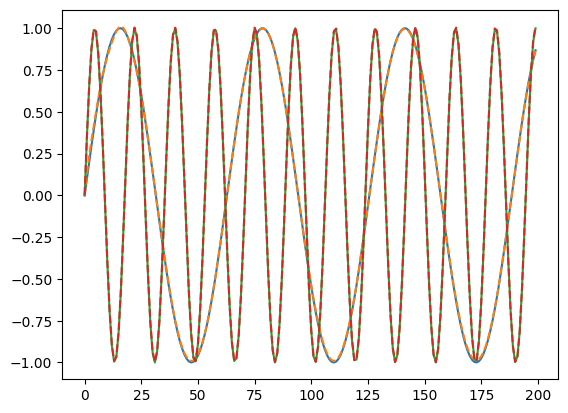

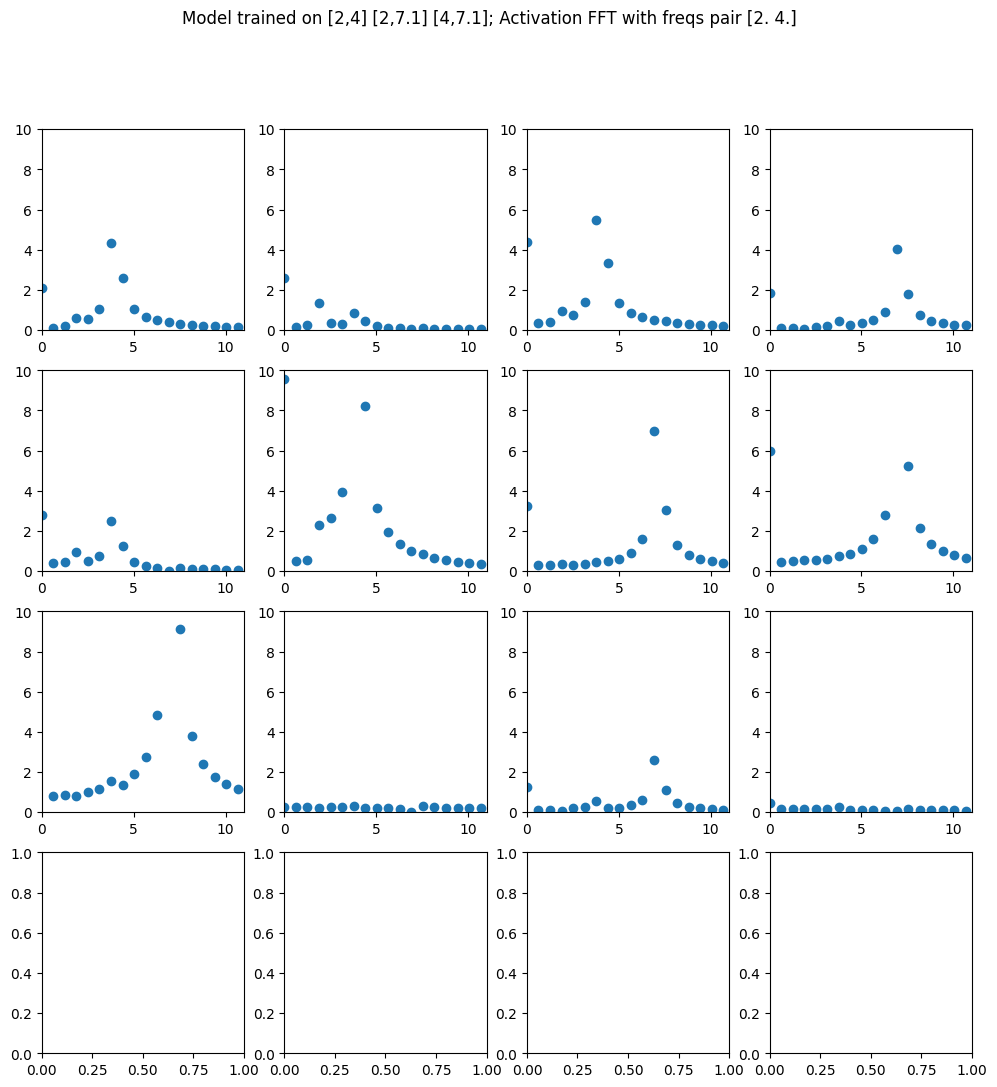

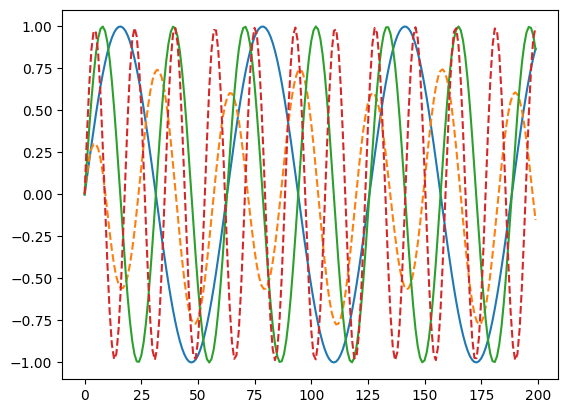

In [8]:

handles =[]

for i, ind in enumerate([[1,2],[0,2],[0,1]]):
    fig, axes = plt.subplots(int(jnp.ceil(jnp.sqrt(K*D))), int(jnp.ceil(jnp.sqrt(K*D))), figsize=(12, 12))
    fig.suptitle(f'Model trained on [2,4] [2,7.1] [4,7.1]; Activation FFT with freqs pair {angular_freqs[jnp.array(ind)]} ')
    key, subkey = jax.random.split(key)
    if len(ind) == 3:
        y_target = datasets[(0,1,1)]
    else:
        _l =np.array([0,0,0])
        _l[ind] = 1
        y_target = datasets[tuple(_l)]
    loss, aux = shooting_student.loss(shooting_student, y_target = y_target, key=subkey, T_pulse = 10, u_index =i)
    fft_result = jnp.fft.fft(aux['x'], axis=0)
    frequencies = jnp.fft.fftfreq(fft_result.shape[0], d=sampling_rate) * 2 * jnp.pi
    
    for i in range(K*D):
        ax = axes[i // int(jnp.ceil(jnp.sqrt(K * D))),
                i % int(jnp.ceil(jnp.sqrt(K * D)))]
        l=ax.scatter(frequencies, jnp.abs(fft_result[:, i]), label = f'{angular_freqs[jnp.array(ind)]}')
        ax.set_xlim(0, 11)
        ax.set_ylim(0,10)
    handles.append(l)
    
    fig = plt.figure()

    for i in range(K):
        plt.plot(y_target[:,i])
        plt.plot(aux['y_pred'][:,i], '--')


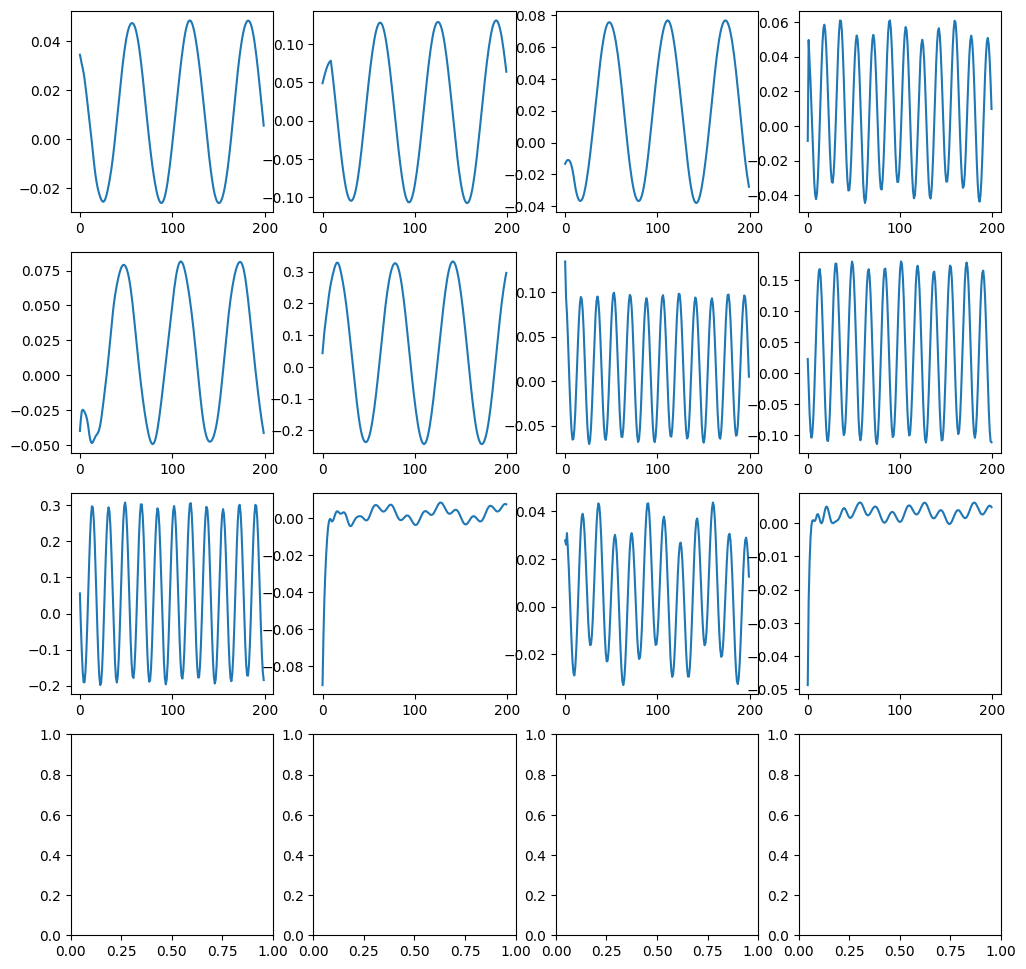

In [7]:
fig, axes = plt.subplots(int(jnp.ceil(jnp.sqrt(K*D))), int(jnp.ceil(jnp.sqrt(K*D))), figsize=(12, 12))
for i in range(K * D):
    ax = axes[i // int(jnp.ceil(jnp.sqrt(K * D))),
              i % int(jnp.ceil(jnp.sqrt(K * D)))]
    ax.plot(shooting_student_aux['x'][:, i])

Text(0.5, 0.98, 'shooting activations fft')

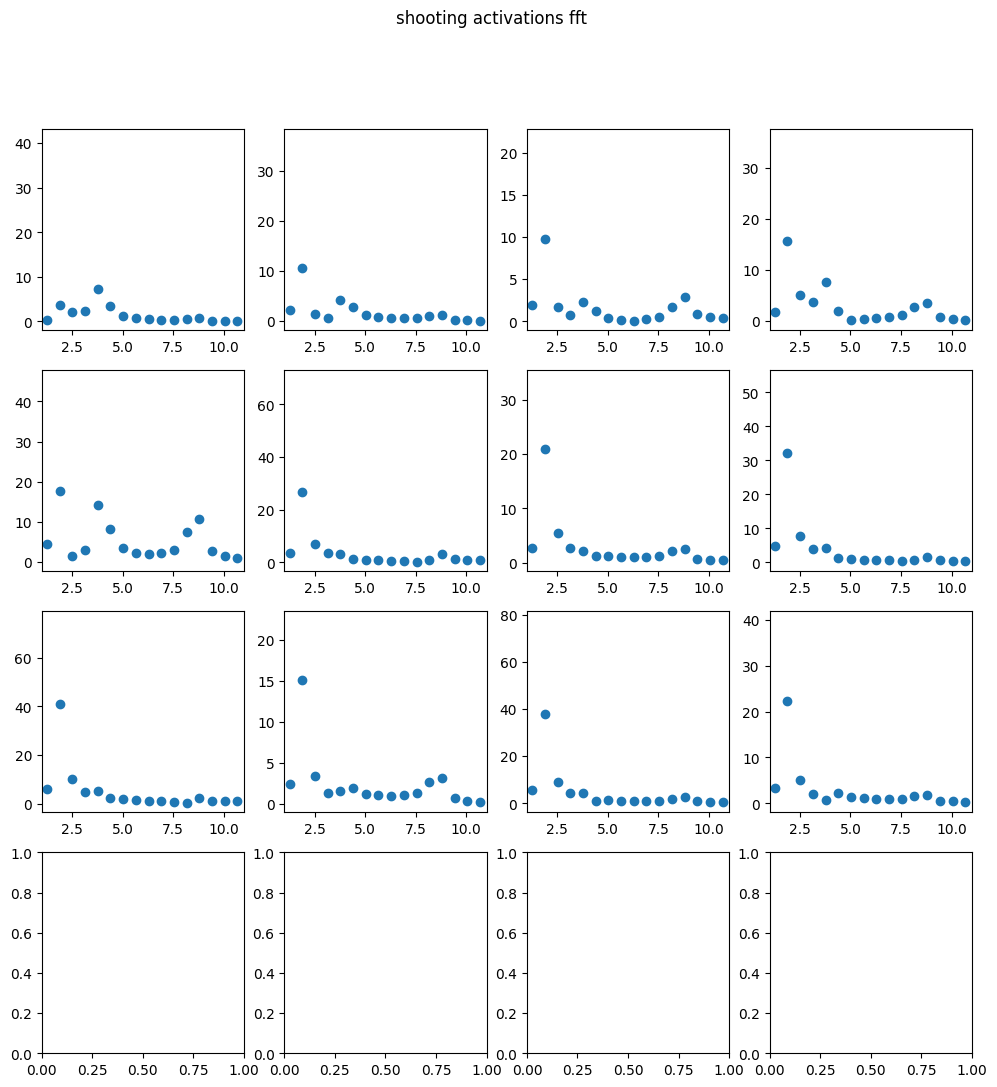

In [89]:
fft_result = jnp.fft.fft(aux['x'], axis=0)
frequencies = jnp.fft.fftfreq(fft_result.shape[0], d=sampling_rate) * 2 * jnp.pi
fig, axes = plt.subplots(int(jnp.ceil(jnp.sqrt(K*D))), int(jnp.ceil(jnp.sqrt(K*D))), figsize=(12, 12))
for i in range(K*D):
    ax = axes[i // int(jnp.ceil(jnp.sqrt(K * D))),
              i % int(jnp.ceil(jnp.sqrt(K * D)))]
    ax.scatter(frequencies, jnp.abs(fft_result[:, i]))
    ax.set_xlim(1, 11)
fig.suptitle('shooting activations fft')